In [1]:
import pandas as pd
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

import cv2

In [2]:
Thickness = pd.read_csv('./data/Thickness.csv')
Thickness = Thickness.drop([33]) # 9-1 drop
Thickness.reset_index(drop=True, inplace=True)
Thickness

,Thickness
0,48.266667
1,47.966667
2,48.166667
3,48.600000
4,59.533333
...,...
122,84.633333
123,98.366667
124,97.033333
125,96.266667


In [3]:
img_path_list = []

for i in range(1, 33):
    for j in range(1, 5):
        if i == 9 and j == 1: 
            continue
        img_path_list.append('./data/test_img/AI-{}_0{}_transformed.jpg'.format(i, j))
        
img_path_list[:5]


['./data/test_img/AI-1_01_transformed.jpg',
 './data/test_img/AI-1_02_transformed.jpg',
 './data/test_img/AI-1_03_transformed.jpg',
 './data/test_img/AI-1_04_transformed.jpg',
 './data/test_img/AI-2_01_transformed.jpg']

In [4]:
Top_path = './data/box_img/Top/'
Bot_path = './data/box_img/Bot/'

In [5]:
top_avg_rgb = []
bot_avg_rgb = []
top_avg_yuv = []
bot_avg_yuv = []

for i in range(len(img_path_list)):
    top = Image.open(Top_path + 'Top_{}.jpg'.format(i))
    bot = Image.open(Bot_path + 'Bot_{}.jpg'.format(i))

    top_yuv = top.convert('YCbCr')
    bot_yuv = bot.convert('YCbCr')

    top_yuv = np.array(top_yuv)
    bot_yuv = np.array(bot_yuv)
    Top_R, Top_G, Top_B = np.mean(top_yuv[:, :, 0]), np.mean(top_yuv[:, :, 1]), np.mean(top_yuv[:, :, 2])
    Bot_R, Bot_G, Bot_B = np.mean(bot_yuv[:, :, 0]), np.mean(bot_yuv[:, :, 1]), np.mean(bot_yuv[:, :, 2])
    top_avg_yuv.append([Top_R, Top_G, Top_B])
    bot_avg_yuv.append([Bot_R, Bot_G, Bot_B])

    top_rgb = np.array(top)
    bot_rgb = np.array(bot)
    Top_R, Top_G, Top_B = np.mean(top_rgb[:, :, 0]), np.mean(top_rgb[:, :, 1]), np.mean(top_rgb[:, :, 2])
    Bot_R, Bot_G, Bot_B = np.mean(bot_rgb[:, :, 0]), np.mean(bot_rgb[:, :, 1]), np.mean(bot_rgb[:, :, 2])
    top_avg_rgb.append([Top_R, Top_G, Top_B])
    bot_avg_rgb.append([Bot_R, Bot_G, Bot_B])

    
    

In [6]:
Table_dataset = pd.DataFrame({'Top_R' : [i[0] for i in top_avg_rgb], 
                              'Top_G' : [i[1] for i in top_avg_rgb], 
                              'Top_B' : [i[2] for i in top_avg_rgb],
                              'Top_Y' : [i[0] for i in top_avg_yuv], 
                              'Top_U' : [i[1] for i in top_avg_yuv], 
                              'Top_V' : [i[2] for i in top_avg_yuv], 
                                 
                              'Bot_R' : [i[0] for i in bot_avg_rgb], 
                              'Bot_G' : [i[1] for i in bot_avg_rgb], 
                              'Bot_B' : [i[2] for i in bot_avg_rgb],
                              'Bot_Y' : [i[0] for i in bot_avg_yuv],
                              'Bot_U' : [i[1] for i in bot_avg_yuv],
                              'Bot_V' : [i[2] for i in bot_avg_yuv],

                              'Thickness': Thickness['Thickness']})

Table_dataset

,Top_R,Top_G,Top_B,Top_Y,Top_U,Top_V,Bot_R,Bot_G,Bot_B,Bot_Y,Bot_U,Bot_V,Thickness
0,11.5760,10.8832,8.1364,10.1816,125.9732,128.0128,30.2140,37.7740,50.4468,36.4324,135.1376,122.7444,48.266667
1,12.4712,12.6248,11.2136,11.9764,127.2032,127.8800,25.9992,34.8912,43.0424,32.7004,133.2408,122.3780,47.966667
2,12.7704,12.7176,9.9168,11.8352,126.3024,127.8544,31.3148,35.7876,41.8260,34.6040,131.2688,125.0896,48.166667
3,11.2308,11.4564,8.8540,10.5828,126.5800,127.8624,24.8812,32.4324,39.4952,30.4976,132.4392,123.3528,48.600000
4,5.4696,3.2120,1.4352,3.2556,126.0720,128.8012,26.0116,32.5420,38.0564,30.5944,131.4472,124.0344,59.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,0.5624,5.0128,22.1704,5.3044,136.9592,123.9120,27.1852,35.2252,42.7796,33.2432,132.9232,122.8544,84.633333
123,0.8864,15.7112,33.7552,12.8660,139.0868,118.5160,28.0672,35.4464,40.1680,33.1776,131.1504,123.5216,98.366667
124,1.0244,13.5756,38.8264,12.1288,142.3968,119.0948,27.8880,36.0608,43.8560,34.0640,133.1264,122.6144,97.033333
125,1.1264,13.7168,35.3488,12.0248,140.6440,119.5596,30.6892,36.6848,45.9800,35.5580,133.3148,123.8992,96.266667


## 0.RGB란?
빛의 삼원색인 빨간색(R), 초록색(G), 파랑색(B)을 의미하며, 이 3가지 색을 가산혼합하여 색을 표현하는 방식이다. 가산혼합은 색을 섞을수록 밝아지는 특징이 있다. 

<img src="https://www.charlezz.com/wordpress/wp-content/uploads/2021/04/www.charlezz.com-rgb-yuv-hsv-6e17c8aa7532463694b4ccbed77aa6a6.jpg" width="300" />


- RGB색상을 회색조(Grayscale)로 변환하기 위해서는 다음의 공식을 사용한다.
- opencv를 이용할 때 imread()로 grascale을 읽는 이미지와 cvtcolor로 rgb를 grayscal로 바꾸는 이미지는 약간의 차이가 있기때문에 주의해야한다.

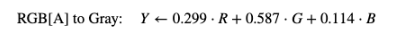

- 사람의 시각이 초록 > 빨간 > 파란으로 예민하게 반응

## 1. YUV란?

YUV(YIQ/YCbCr/YPbPr)는 색을 구성하는 방법 중 하나로 휘도(Y)와 청색 색차(U), 적색 색차(V) 정보로 색을 구성한다.

YUV는 인간의 시각 체계에서 시작한 개념으로, 사람눈에 민감한 휘도(밝기)성분과 상대적으로 덜 민감한 색상 성분으로 분리한다. 
Y는 밝기를 의미하며, U는 파랑색 성분에서 밝기값을 뺀것이고, V는 빨강색 성분에서 밝기값을 뺀것이다.

Y = 밝기
U = 파랑색 - 밝기
V = 빨강색 - 밝기



<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F990CF63A5B7796E920" width="300" style="float:left" />
<img src="https://www.charlezz.com/wordpress/wp-content/uploads/2021/04/www.charlezz.com-rgb-yuv-hsv-screenshot-2.png" width="500" />

## 2. HSV란?

HSV는 Hue(색상), Saturation(채도), Value(명도)를 나타냅니다. 원의 각도를 통해 색상을, 원의 중심에서 얼마나 멀어져 있느냐로 채도를, 높이가 어느정도인가로 명도를 나타냅니다.

색상(H)은 0~360도의 범위를 갖지만, 8비트 범위내에서 표현할 때는 0~255까지밖에 표현하지 못하기 때문에 H값을 0~179범위내로 표현한다. 

채도(S)는 특정한 색상의 가장 진한 상태를 8비트로 표현할 때 255로 나타내며 색상의 진함 정도를 나타낸다. 0이면 같은 명도의 무채색을 나타낸다.

명도(V)는 밝은 정도를 나타내며 흰색이 255면 검은색은 0이다.

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fbs4Onp%2FbtqOKYm3K9h%2FPATLA8ClkQp3fszSYCjr60%2Fimg.jpg" width="340" />

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FCWmcC%2FbtqOUlt1w1A%2FzjhU8WqHzSER2G7teHPYj1%2Fimg.jpg" width="250" />



이외에도 
- CMYK (Cyan, Magenta, Yellow, Key/Black) : 인쇄 분야에서 사용되는 색 공간


- Lab : 
밝기(Lightness) 적록과 황청(a Channel, b Channel)

<img src="https://i.namu.wiki/i/Pp8pphsHEJpO8aSl_hHrOqTWJLZ4Gdne7BQ4Nrz_kmL7-_GpKjoFDwYtKiXDcYpMDbUpJxJKcnxDgkQtuTE2MWqanpgGYr5rix0upsIsdLLHzGNLLbvprrrwjZq-OlxilELVecv2hyJy1lvfi4bCeg.webp" width="250" />

## feature 상관도
- 현재는 YUV만

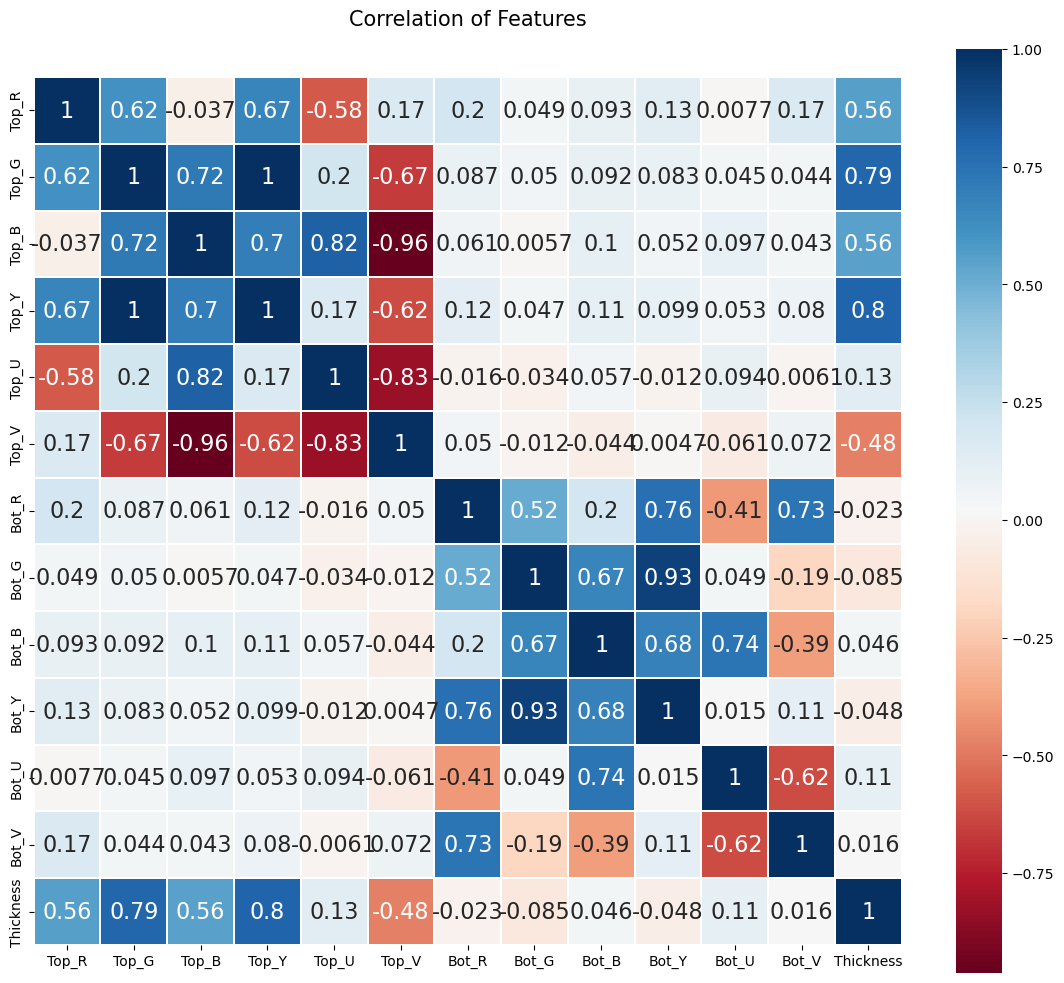

In [7]:
import seaborn as sns

heatmap_data = Table_dataset[['Top_R', 'Top_G',	'Top_B', 'Top_Y', 'Top_U', 'Top_V',
                              'Bot_R', 'Bot_G',	'Bot_B', 'Bot_Y', 'Bot_U', 'Bot_V',	'Thickness']] 

colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 16})

del heatmap_data

#### 강한 양의 상관, 음의 상관 관계인 TOP_R, TOP_G, TOP_B, TOP_Y, TOP_V만 넣고 실험

In [8]:
Table_dataset_RGBYV = Table_dataset.drop(['Top_U', 'Bot_R', 'Bot_G', 'Bot_B', 'Bot_Y', 'Bot_U', 'Bot_V'], axis=1)
Table_dataset_RGBYV

,Top_R,Top_G,Top_B,Top_Y,Top_V,Thickness
0,11.5760,10.8832,8.1364,10.1816,128.0128,48.266667
1,12.4712,12.6248,11.2136,11.9764,127.8800,47.966667
2,12.7704,12.7176,9.9168,11.8352,127.8544,48.166667
3,11.2308,11.4564,8.8540,10.5828,127.8624,48.600000
4,5.4696,3.2120,1.4352,3.2556,128.8012,59.533333
...,...,...,...,...,...,...
122,0.5624,5.0128,22.1704,5.3044,123.9120,84.633333
123,0.8864,15.7112,33.7552,12.8660,118.5160,98.366667
124,1.0244,13.5756,38.8264,12.1288,119.0948,97.033333
125,1.1264,13.7168,35.3488,12.0248,119.5596,96.266667


In [9]:
X_train, X_test, y_train, y_test = train_test_split(Table_dataset_RGBYV.iloc[:, :-1], Table_dataset_RGBYV.iloc[:, -1], test_size=0.3, random_state=42)

##### 2nd_try_AUTOML_based.ipynb

#### ref
- Best pipeline: RidgeCV(XGBRegressor(PolynomialFeatures(LinearSVR(input_matrix, C=15.0, dual=False, epsilon=0.001, loss=squared_epsilon_insensitive, tol=0.01), degree=2, include_bias=False, interaction_only=False), learning_rate=0.01, max_depth=4, min_child_weight=9, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.3, verbosity=0))
- score :187.9604692177386

#### not ref
- Best pipeline: AdaBoostRegressor(input_matrix, learning_rate=1.0, loss=linear, n_estimators=100)
- score : 84.46143049678001

##### 3nd_corrected_AutoML.ipynb

#### ref+weight
- Best pipeline: AdaBoostRegressor(SelectFwe(XGBRegressor(input_matrix, learning_rate=0.01, max_depth=7, min_child_weight=20, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.6000000000000001, verbosity=0), alpha=0.032), learning_rate=0.5, loss=square, n_estimators=100)
- score : 35.573272807034115

##### 2nd_try_AUTOML_based.ipynb

#### ref
- Best pipeline: RidgeCV(XGBRegressor(PolynomialFeatures(LinearSVR(input_matrix, C=15.0, dual=False, epsilon=0.001, loss=squared_epsilon_insensitive, tol=0.01), degree=2, include_bias=False, interaction_only=False), learning_rate=0.01, max_depth=4, min_child_weight=9, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.3, verbosity=0))
- score :187.9604692177386

#### not ref
- Best pipeline: AdaBoostRegressor(input_matrix, learning_rate=1.0, loss=linear, n_estimators=100)
- score : 84.46143049678001

##### 3nd_corrected_AutoML.ipynb

#### ref+weight
- Best pipeline: AdaBoostRegressor(SelectFwe(XGBRegressor(input_matrix, learning_rate=0.01, max_depth=7, min_child_weight=20, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.6000000000000001, verbosity=0), alpha=0.032), learning_rate=0.5, loss=square, n_estimators=100)
- score : 35.573272807034115

In [10]:
from tpot import TPOTRegressor

tpot =  TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42, cv=5, n_jobs = -1)
tpot.fit(X_train, y_train)

tpot.export('tpot_pipeline_cv.py')

                                                                              
Best pipeline: AdaBoostRegressor(input_matrix, learning_rate=1.0, loss=exponential, n_estimators=100)


### 🎯 첫번째 모델

tpot =  TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42, cv=5, n_jobs = -1)


Best pipeline: 
AdaBoostRegressor(input_matrix, learning_rate=1.0, loss=exponential, n_estimators=100)

score : 52.04407861571632

In [11]:
y_pred = tpot.predict(X_test)
y_pred

array([ 72.41818182,  62.21388889,  72.96666667,  97.83703704,
        89.72807018,  63.75185185,  72.84761905,  91.18684211,
        63.94242424, 108.56969697,  97.56      ,  61.8       ,
        84.17435897,  62.35      ,  83.44022988, 103.19000001,
        87.35906433,  83.47777778,  67.31904762,  84.17435897,
        68.43030303,  63.7       ,  84.64197531, 153.3       ,
        48.17619048, 119.97333334, 101.30666669, 101.30666669,
        72.41818182,  84.3969697 ,  63.16666667,  71.28627451,
        72.96666667, 108.76666667,  92.47777778, 101.80416668,
        72.65333333, 153.3       ,  75.12121212])

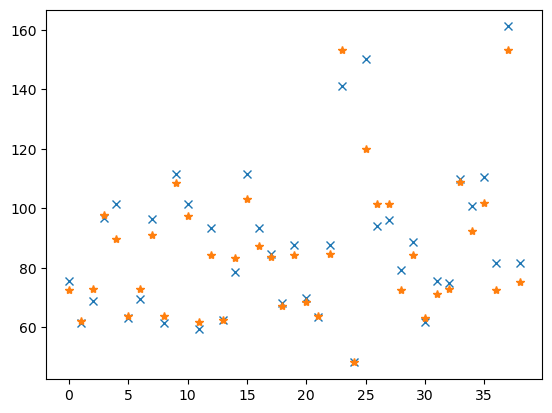

In [12]:
plt.plot(y_test.values,'x', label = 'True')
plt.plot(y_pred,'*', label = 'Predict')

In [13]:
pd.DataFrame({'True': y_test.values, 'Predict': y_pred})

,True,Predict
0,75.533333,72.418182
1,61.300000,62.213889
2,68.700000,72.966667
3,96.633333,97.837037
4,101.466667,89.728070
5,63.166667,63.751852
6,69.433333,72.847619
7,96.266667,91.186842
8,61.466667,63.942424
9,111.533333,108.569697


In [14]:
mse = np.mean((y_test.values - y_pred)**2)
mse

52.04407861571632

In [15]:
# 테스트 세트에서의 RMSE 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

7.2141582056201345

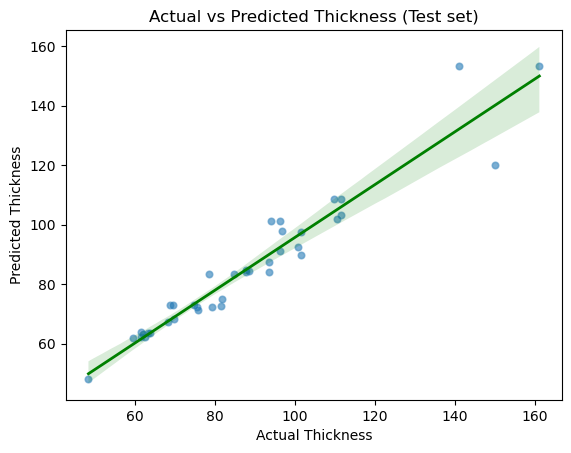

In [16]:
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
sns.regplot(x=y_test, y=y_pred, scatter_kws={'s': 20, 'alpha':0.3}, line_kws={'color':'green', 'linewidth': 2}, robust=True)

plt.xlabel('Actual Thickness')
plt.ylabel('Predicted Thickness')
plt.title('Actual vs Predicted Thickness (Test set)')
plt.show()

#### 💡 변화하는 generations과 population_size에 따른 성능 차이 <br>
- generations와 population_size 파라미터를 변경함에 따라 모델의 성능은 크게 변화하는 걸 볼 수 있습니다. 동일한 모델이라 하더라도, 선택한 파라미터에 따라 결과가 크게 달라질 수 있습니다.<br>
- Best pipeline: AdaBoostRegressor(RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.1, min_samples_leaf=19, min_samples_split=19, n_estimators=100), learning_rate=1.0, loss=exponential, n_estimators=100)<br>
- 위의 파이프라인에서, AdaBoostRegressor와 RandomForestRegressor는 동일한 모델을 사용하고 있지만, 각 모델의 설정(하이퍼파라미터)이 다릅니다. 모델의 성능이 선택한 파라미터에 크게 의존하기 때문에, 최적의 파라미터를 찾는 과정이 필요할 것 같습니다.

### 🎯 두번째 모델

tpot =  TPOTRegressor(generations=20, population_size=5, verbosity=2, random_state=42, cv=3, n_jobs = -1)
tpot.fit(X_train, y_train)

Best pipeline: AdaBoostRegressor(RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.1, min_samples_leaf=19, min_samples_split=19, n_estimators=100), learning_rate=1.0, loss=exponential, n_estimators=100)

score : 45.09186396960005

In [17]:
tpot =  TPOTRegressor(generations=20, population_size=5, verbosity=2, random_state=42, cv=3, n_jobs = -1)
tpot.fit(X_train, y_train)

tpot.export('tpot_pipeline_cv.py')

                                                                            
Generation 1 - Current best internal CV score: -118.57136404826265
                                                                             
Generation 2 - Current best internal CV score: -118.57136404826265
                                                                             
Generation 3 - Current best internal CV score: -68.93550789307552
                                                                             
Generation 4 - Current best internal CV score: -68.93550789307552
                                                                             
Generation 5 - Current best internal CV score: -62.76111055618878
                                                                             
Generation 6 - Current best internal CV score: -61.00195620948694
                                                                             
Generation 7 - Current best internal CV score: -61.001956

In [18]:
y_pred = tpot.predict(X_test)
y_pred

/home/hakki/anaconda3/envs/torch2.0/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([ 71.72962963,  62.65740741,  72.65714286,  99.07407406,
        94.62857143,  63.12      ,  72.41818182,  91.43777778,
        65.05714286, 109.3       ,  98.55925926,  62.32222222,
        83.11185185,  62.22222222,  82.45555555, 102.62500001,
        86.70130719,  82.57051282,  67.71282051,  83.11185185,
        70.47037037,  63.12      ,  83.26790123, 153.3       ,
        52.14444445, 124.4333333 , 100.63939395, 100.63939395,
        72.20588235,  83.26790123,  62.99333333,  70.87575758,
        72.60634921, 109.4333333 ,  93.97066666, 100.63939395,
        72.60634921, 153.3       ,  75.19487179])

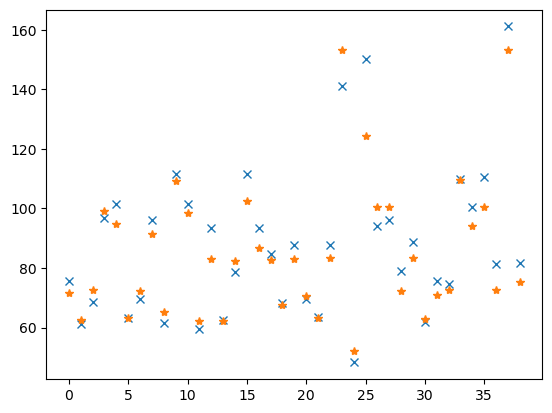

In [19]:
plt.plot(y_test.values,'x', label = 'True')
plt.plot(y_pred,'*', label = 'Predict')

In [20]:
pd.DataFrame({'True': y_test.values, 'Predict': y_pred})

,True,Predict
0,75.533333,71.729630
1,61.300000,62.657407
2,68.700000,72.657143
3,96.633333,99.074074
4,101.466667,94.628571
5,63.166667,63.120000
6,69.433333,72.418182
7,96.266667,91.437778
8,61.466667,65.057143
9,111.533333,109.300000


In [21]:
mse = np.mean((y_pred - y_test)**2)
mse

45.09186396960005

In [22]:
# 테스트 세트에서의 RMSE 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

6.71504757761254

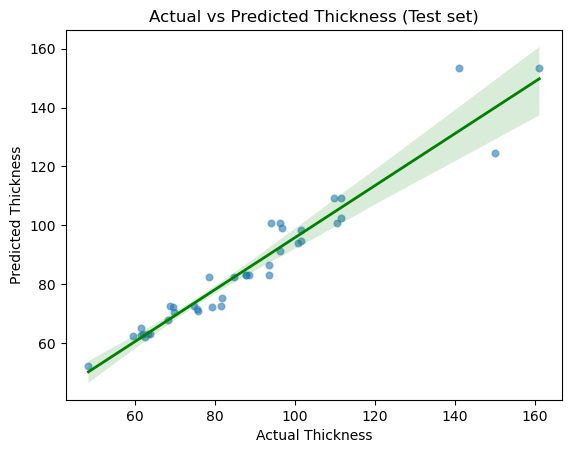

In [23]:
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
sns.regplot(x=y_test, y=y_pred, scatter_kws={'s': 20, 'alpha':0.3}, line_kws={'color':'green', 'linewidth': 2}, robust=True)

plt.xlabel('Actual Thickness')
plt.ylabel('Predicted Thickness')
plt.title('Actual vs Predicted Thickness (Test set)')
plt.show()

### 🎯 세번째 모델

tpot =  TPOTRegressor(generations=20, population_size=5, verbosity=2, random_state=42, cv=3, n_jobs = -1)
tpot.fit(X_train, y_train)

Best pipeline: AdaBoostRegressor(RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.1, min_samples_leaf=19, min_samples_split=19, n_estimators=100), learning_rate=1.0, loss=exponential, n_estimators=100)

score : 107.6917622159578

In [24]:
tpot =  TPOTRegressor(generations=30, population_size=5, verbosity=2, random_state=41, cv=5, n_jobs = -1)
tpot.fit(X_train, y_train)

tpot.export('tpot_pipeline_cv.py')

                                                                            
Generation 1 - Current best internal CV score: -120.84969897663584
                                                                             
Generation 2 - Current best internal CV score: -117.25180878064707
                                                                             
Generation 3 - Current best internal CV score: -117.25180878064707
                                                                             
Generation 4 - Current best internal CV score: -63.59677080169804
                                                                             
Generation 5 - Current best internal CV score: -63.59677080169804
                                                                             
Generation 6 - Current best internal CV score: -63.59677080169804
                                                                             
Generation 7 - Current best internal CV score: -63.20812

In [25]:
y_pred = tpot.predict(X_test)
y_pred

/home/hakki/anaconda3/envs/torch2.0/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([ 73.29393939,  61.73333333,  73.29393939,  94.375     ,
        98.48888889,  61.73333333,  73.29393939,  94.375     ,
        68.27777778, 120.45416666,  98.48888889,  61.73333333,
        79.66666667,  61.73333333,  81.33333333, 104.68333335,
        79.66666667,  81.33333333,  65.28333333,  83.98571429,
        65.28333333,  61.73333333,  83.98571429, 120.45416666,
        48.24444445, 120.45416666,  94.375     ,  94.375     ,
        73.29393939,  83.98571429,  61.73333333,  61.73333333,
        73.29393939, 120.45416666,  94.375     , 104.68333335,
        73.29393939, 120.45416666,  76.39583333])

,True,Predict
0,75.533333,73.293939
1,61.300000,61.733333
2,68.700000,73.293939
3,96.633333,94.375000
4,101.466667,98.488889
5,63.166667,61.733333
6,69.433333,73.293939
7,96.266667,94.375000
8,61.466667,68.277778
9,111.533333,120.454167


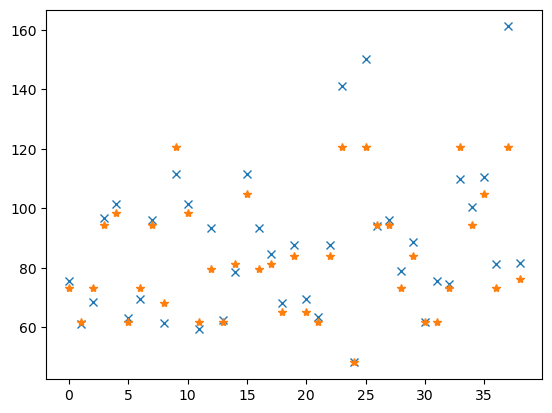

In [26]:
plt.plot(y_test.values,'x', label = 'True')
plt.plot(y_pred,'*', label = 'Predict')

pd.DataFrame({'True': y_test.values, 'Predict': y_pred})

In [27]:
mse = np.mean((y_pred - y_test)**2)
mse

107.6917622159578

In [28]:
# 테스트 세트에서의 RMSE 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

10.377464151513982

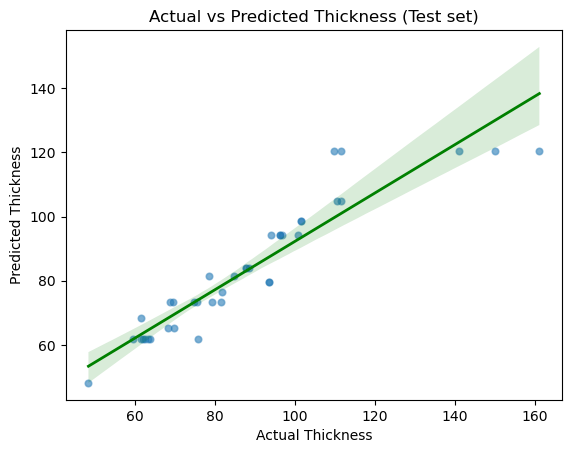

In [29]:
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
sns.regplot(x=y_test, y=y_pred, scatter_kws={'s': 20, 'alpha':0.3}, line_kws={'color':'green', 'linewidth': 2}, robust=True)

plt.xlabel('Actual Thickness')
plt.ylabel('Predicted Thickness')
plt.title('Actual vs Predicted Thickness (Test set)')
plt.show()

# 추후 작업

1. color space간의 상관도를 이용해서 feature변경하면서 TPOT으로 모델 적용시켜보기

2. TPOT으로 어느 정도 feature를 정한 후 하이퍼파라미터 조정하기

 - 테이블 데이터은 보통 그래디언트 부스팅 알고리즘의 성능이 압도적이기 때문에 이러한 알고리즘 계열의 Adaboost, catboost, xgboost가 좋은 성능을 보입니다. 제 경험으로도 경연대회 때 테이블 데이터들은 이 3가지 알고리즘들이 대부분 1등하는걸로 알고있습니다.

 - 그래디언트 부스팅 알고리즘이란? 예측 모델을 연속적으로 개선시켜서 약한 예측 모델을 강력한 하나의 모델로 만드는 방법입니다. 이 방법은 첫 번째 모델의 오차를 줄이는 두 번째 모델을 만들고, 두 번째 모델의 오차를 줄이는 세 번째 모델을 만들고, 이런 과정을 반복하는 방식으로 작동합니다.